In [44]:
import numpy as np
import sknn
from sknn import mlp
import tic_tac_toe as ttt
from numpy import random
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)



In [ ]:
with open('value_policy_3.pkl','rb') as file_:
    value,policy = pickle.load(file_)

In [45]:
value = mlp.Regressor([mlp.Layer('Rectifier',units = 200),
               mlp.Layer('Tanh',units = 1)],
              learning_rate = 0.001,
              batch_size = 1,
              n_iter = 1)
value.fit(np.zeros((16,9)) , np.zeros(16))

policy = mlp.Regressor([mlp.Layer('Rectifier',units = 1000),
                        #mlp.Layer('Rectifier',units = 250),
               mlp.Layer('Tanh',units = 9,dropout=0.)],
              learning_rate = 0.01,
              batch_size = 10,
              n_iter = 1)
policy.fit(np.zeros((1,9)) , np.zeros((1,9)))

Regressor(batch_size=10, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: units=1000, name=u'hidden0', frozen=False>,
     layers=[<sknn.nn.Layer `Rectifier`: units=1000, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Tanh`: units=9, name=u'output', frozen=False, dropout=0.0>],
     learning_momentum=0.9, learning_rate=0.01, learning_rule=u'sgd',
     loss_type=None, n_iter=1, n_stable=10, normalize=None,
     output=<sknn.nn.Layer `Tanh`: units=9, name=u'output', frozen=False, dropout=0.0>,
     parameters=None, random_state=None, regularize=None, valid_set=None,
     valid_size=0.0, verbose=None, warning=None, weight_decay=None)

In [46]:
Temp = 0.1
class value_bot():
    def __init__(self, value):
        self.value = value
    def make_move(self,board,turn):
        return value_move(board,turn,self.value)
def value_move(board,turn,value):
    board = np.copy(board)
    if turn == -1:
        board = -1 * board
    options = ttt.available_moves(board)
    values = {}
    for move in options:
        ttt.update_move(board,move,1)
        if ttt.is_over(board):
            values[move] = ttt.winner(board)
        else:
            values[move] = -1 * value.predict(-1 * board.reshape((1,9)))[0]
        ttt.unupdate_move(board,move)
    action_values = values.items()
    probs = softmax(np.array(zip(*action_values)[1]))
    r = random.random()
    for i in range(len(probs)):
        r-=probs[i]
        if r <0:
            move = i
            break
    return action_values[move]
        
class policy_bot():
    def __init__(self, policy):
        self.policy = policy
    def make_move(self,board,turn):
        return policy_move(board,turn,self.policy)
def policy_move(board,turn,policy):
    board = np.copy(board)
    if turn == -1:
        board = -1 * board
    action_values = zip(range(9),list(policy.predict(board.reshape(1,(9)))[0]))
    #print action_values
    probs = softmax(np.array(zip(*action_values)[1]))
    #print probs
    r = random.random()
    for i in range(len(probs)):
        r-=probs[i]
        if r <0:
            move = i
            break
    return action_values[move]

def sym_policy(state,policy):
    state = state.reshape((3,3))
    states = [np.copy(state), np.copy(state.T)]
    for i in range(3):
        state = np.rot90(state)
        states += [np.copy(state),np.copy(state.T)]
    states = np.array(states)
    pols = policy.predict(states).reshape(8,3,3)
    pols[1] = pols[1].T
    pols[2] = np.rot90(pols[2],3)
    pols[3] = np.rot90(pols[3].T,3)
    pols[4] = np.rot90(pols[4],2)
    pols[5] = np.rot90(pols[5].T,2)
    pols[6] = np.rot90(pols[6],1)
    pols[7] = np.rot90(pols[7].T,1)
    vals = sum(pols) * 0.125
    return vals
    
def softmax(ar):
#    print ar
    ar -= np.max(ar)
    exp = np.exp(ar / Temp)
    return exp / np.sum(exp)

In [47]:
replay = []
history = []
discount = 1
X_train= []
y_train=[]
rewards = []
actions = []

In [ ]:
import time
f, ((ax11, ax12 ,ax13,ax14),(ax21, ax22 ,ax23,ax24),(ax31, ax32 ,ax33,ax34)) = plt.subplots(3, 4, sharey=True)
f.suptitle("Games Played: {:d}".format(game),fontsize = 36)

axes = []
for i in range(1,13):
    axes.append(plt.subplot(3,4,i, aspect='equal', adjustable='box-forced'))
for game in range(1000000):
    
        
    result = {'log' : [],
              'winner' : None,
              'boards' :[]}
    board = ttt.empty_board()
    turn = 1
    t0 = time.clock()
    while not ttt.is_over(board):
        result['boards'].append(np.copy(board))
        old_board = np.copy(board)
        action,_ = policy_move(board,1,policy)
        result['log'] += [action]
        if board[action] == 0:
            ttt.update_move(board,action,1)
        else:
            result['winner'] = -1*turn*2
            break
        if ttt.is_over(board):
            result['winner'] = turn * ttt.winner(board)
        board = -1 * board
        turn =  -1 * turn
    t1 = time.clock()
    
#     history.append(result)
    train_index = random.randint(0, len(result['log']))
    train_action = result['log'][train_index]
    train_board = result['boards'][train_index]
    reward = result['winner'] * (1 - (train_index%2) * 2)  #swap result if board is from player 2's perspective
    
    ############################################################
    #################### train on the result ###################
    ############################################################

    X_train.append(train_board)
    rewards.append(reward)
    actions.append(train_action)
    
    if len(X_train) >=100:
        y_train = map(lambda x: policy.predict(x.reshape((1,9)))[0] , X_train)
        for i , tar in enumerate(y_train):
            tar[actions[i]] = rewards[i]
        
        #replay += zip(X_train,y_train)
        
        policy.fit(np.array(X_train),np.array(y_train))
        value.fit(np.array(X_train),np.array(rewards))
        X_train = []
        rewards = []
        actions = []
    t2 = time.clock()
    #print 'game time = {}, train time = {}'.format(t1-t0,t2-t1)
    
    if game%1000 == 0:
        f.suptitle("Games Played: {:d}".format(game),fontsize = 36)
        for ax in axes:
            ax.cla()
        
        state = np.array([0,0,0,0,-1,0,0,0,0]).reshape((3,3))
        answer = np.array([0,-1,0,-1,-1,-1,0,-1,0]).reshape((3,3))
        opinion = policy.predict(state.reshape((1,9)))[0].reshape((3,3))

        sym = sym_policy(state,policy)
                
        
        #plt.figure(1)

        axes[0].matshow(state,vmin=-1,vmax=1,cmap = 'seismic')
        #ax1.set_aspect('equal')
        #plt.figure(2)
        
        axes[1].matshow(opinion,vmin=-1,vmax=1,cmap = 'seismic_r')
        
        
        axes[2].matshow(sym,vmin=-1,vmax=1,cmap = 'seismic_r')
        #ax1.set_aspect('equal')
        
        axes[3].matshow(answer,vmin=-1,vmax=1,cmap = 'seismic_r')
        state = np.array([-1,0,-1,0,0,0,1,1,0]).reshape((3,3))
        answer = np.array([-1,discount**2,-1,-discount,-discount,-discount,-1,-1,1]).reshape((3,3))
        opinion = policy.predict(state.reshape((1,9)))[0].reshape((3,3))
        sym = sym_policy(state,policy)
        
        #plt.figure(1)
        axes[4].matshow(state,vmin=-1,vmax=1,cmap = 'seismic')
        #ax1.set_aspect('equal')
        #plt.figure(2)
        axes[5].matshow(opinion,vmin=-1,vmax=1,cmap = 'seismic_r')
        
        axes[6].matshow(sym,vmin=-1,vmax=1,cmap = 'seismic_r')
        #ax1.set_aspect('equal')
        axes[7].matshow(answer,vmin=-1,vmax=1,cmap = 'seismic_r')
        state = np.array([-1,0,-1,-1,1,1,1,1,-1]).reshape((3,3))
        answer = np.array([-1,1,-1,-1,-1,-1,-1,-1,-1]).reshape((3,3))
        opinion = policy.predict(state.reshape((1,9)))[0].reshape((3,3))
        sym = sym_policy(state,policy)
        #plt.figure(1)
        axes[8].matshow(state,vmin=-1,vmax=1,cmap = 'seismic')
        #ax1.set_aspect('equal')
        #plt.figure(2)
        axes[9].matshow(opinion,vmin=-1,vmax=1,cmap = 'seismic_r')
        
        axes[10].matshow(sym,vmin=-1,vmax=1,cmap = 'seismic_r')
        #ax1.set_aspect('equal')
        axes[11].matshow(answer,vmin=-1,vmax=1,cmap = 'seismic_r')
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf())
        
        with open('value_policy3.pkl','wb') as file_:
            pickle.dump((value,policy),file_)

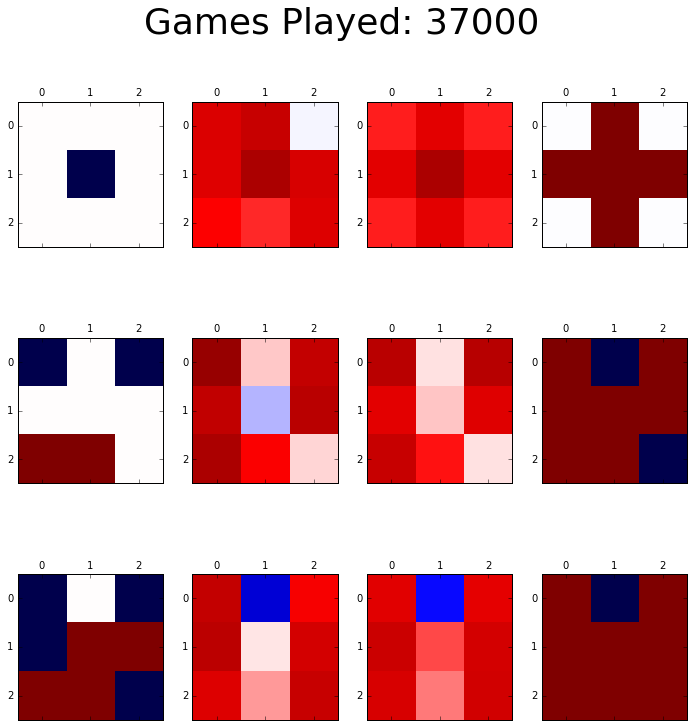

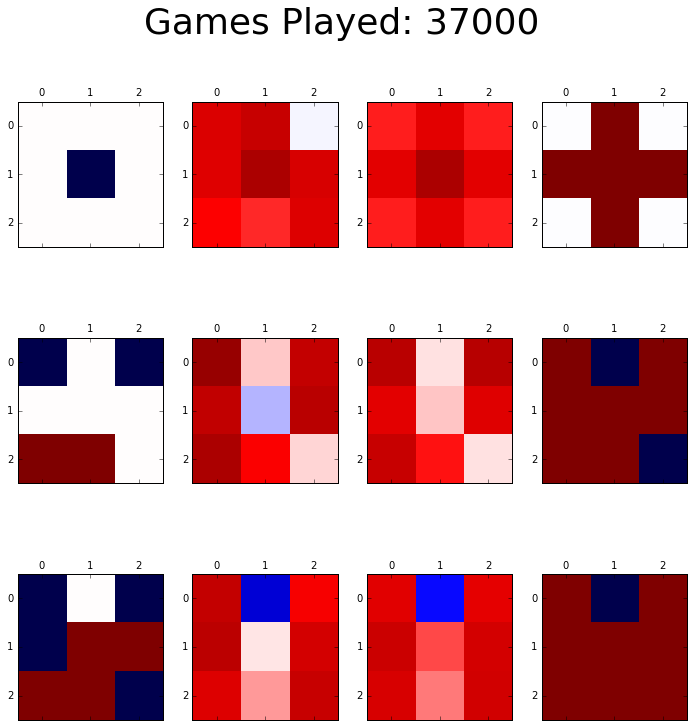

In [52]:
with open('value_policy3.pkl','rb') as file_:
    value,policy = pickle.load(file_)
    
f,_ = plt.subplots(3, 4, sharey=True)   
axes = []
for i in range(1,13):
    axes.append(plt.subplot(3,4,i, aspect='equal', adjustable='box-forced'))
f.suptitle("Games Played: {:d}".format(game),fontsize = 36)
for ax in axes:
    ax.cla()

state = np.array([0,0,0,0,-1,0,0,0,0]).reshape((3,3))
answer = np.array([0,-1,0,-1,-1,-1,0,-1,0]).reshape((3,3))
opinion = policy.predict(state.reshape((1,9)))[0].reshape((3,3))

sym = sym_policy(state,policy)


#plt.figure(1)

axes[0].matshow(state,vmin=-1,vmax=1,cmap = 'seismic')
#ax1.set_aspect('equal')
#plt.figure(2)

axes[1].matshow(opinion,vmin=-1,vmax=1,cmap = 'seismic_r')


axes[2].matshow(sym,vmin=-1,vmax=1,cmap = 'seismic_r')
#ax1.set_aspect('equal')

axes[3].matshow(answer,vmin=-1,vmax=1,cmap = 'seismic_r')
state = np.array([-1,0,-1,0,0,0,1,1,0]).reshape((3,3))
answer = np.array([-1,discount**2,-1,-discount,-discount,-discount,-1,-1,1]).reshape((3,3))
opinion = policy.predict(state.reshape((1,9)))[0].reshape((3,3))
sym = sym_policy(state,policy)

#plt.figure(1)
axes[4].matshow(state,vmin=-1,vmax=1,cmap = 'seismic')
#ax1.set_aspect('equal')
#plt.figure(2)
axes[5].matshow(opinion,vmin=-1,vmax=1,cmap = 'seismic_r')

axes[6].matshow(sym,vmin=-1,vmax=1,cmap = 'seismic_r')
#ax1.set_aspect('equal')
axes[7].matshow(answer,vmin=-1,vmax=1,cmap = 'seismic_r')
state = np.array([-1,0,-1,-1,1,1,1,1,-1]).reshape((3,3))
answer = np.array([-1,1,-1,-1,-1,-1,-1,-1,-1]).reshape((3,3))
opinion = policy.predict(state.reshape((1,9)))[0].reshape((3,3))
sym = sym_policy(state,policy)
#plt.figure(1)
axes[8].matshow(state,vmin=-1,vmax=1,cmap = 'seismic')
#ax1.set_aspect('equal')
#plt.figure(2)
axes[9].matshow(opinion,vmin=-1,vmax=1,cmap = 'seismic_r')

axes[10].matshow(sym,vmin=-1,vmax=1,cmap = 'seismic_r')
#ax1.set_aspect('equal')
axes[11].matshow(answer,vmin=-1,vmax=1,cmap = 'seismic_r')
IPython.display.clear_output(wait=True)
IPython.display.display(plt.gcf())

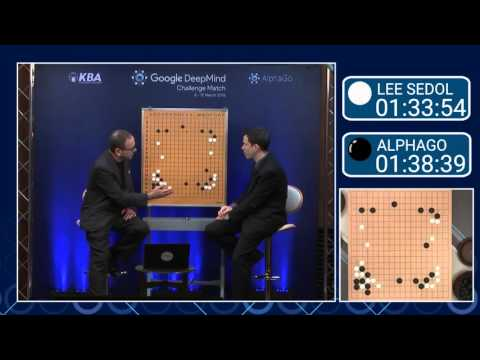

In [59]:
from IPython.display import YouTubeVideo
# a talk about IPython at Sage Days at U. Washington, Seattle.
# Video credit: William Stein.
YouTubeVideo('JNrXgpSEEIE',start = 28,width = 800,height = 600,)